# Using Datasets for Image Loading

This notebook is a tutorial accompying the manuscript "Perspectives: Comparison of Deep Learning Based Segmentation Models on Typical Biophysics and Biomedical Data" by JS Bryan IV, M Tavakoli, and S Presse. In this tutorial, we will learn the basics of using `Dataset` and `DataLoader` classes in PyTorch. We will create our own datasets to load the data referenced in the accompying manuscript.

**Before reading this tutorial, make sure you have properly installed PyTorch and downloaded the data as explained in this repository's README.**

## Introduction

Welcome to this tutorial on PyTorch Datasets! This guide will walk you through the essential concepts of data handling in PyTorch, covering everything from manual data loading to creating custom Dataset classes and integrating them into your training loops using DataLoaders. The specific aim of this tutorial is to explain the datasets used in our accompanying manuscript, which can be found in `data/bdello.py`, `data/neurons.py`, and `data/retinas.py`.

Datasets in PyTorch are crucial for efficient data management and preprocessing, ensuring that your training pipeline is organized and streamlined. By encapsulating the logic needed to access, transform, and augment data, PyTorch Datasets keep your code clean and maintainable, ultimately leading to better performance and accuracy in your machine learning models. DataLoaders complement Datasets by enabling easy batching, shuffling, and loading of data in parallel, further enhancing the efficiency and scalability of your training process.

### Importing Libraries

To get started, we need to import several essential libraries. These libraries will help us handle file paths, load images, and utilize PyTorch functionalities for creating and managing datasets. Here are the libraries we will use:

* os: To handle file paths.
* PIL (Python Imaging Library): To load and manipulate images.
* torch: To access PyTorch functionalities.
* torchvision.transforms: To apply transformations to the images.
* torch.utils.data.Dataset: To create custom datasets.
* torch.utils.data.DataLoader: To manage and load data in batches.
* matplotlib.pyplot: To visualize the images.

Let's import these libraries:

In [2]:
# Import libraries
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

/home/jsbryan4/Desktop/Projects/BioModelComparison/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data without Datasets

Now that we have imported the necessary libraries, let us start by simply loading images without using PyTorch Datasets. This will help us understand the importance of Datasets and DataLoaders in managing data efficiently. Specifically, let us load the images and masks from the phase-contrast bdellovibrio dataset, which we will refer to as the "bdello" dataset.

The bdello datset is located in the 'data/bdello' directory, which contains two subdirectories: 'images' and 'masks'. The 'images' directory contains the phase-contrast images of bdellovibrio bacteria, while the 'masks' directory contains the corresponding binary masks that segment the bacteria from the background. Each image and mask is named using the same identifier, such as 'img1.png' or 'img2.png'.

In the code below we load the images and masks using `PIL.Image` through `Image.open()`, then convert them to tensors using `torchvision.transforms.ToTensor()`. We then rescale the images using `torch.nn.functional.avg_pool2d()` to reduce their size for visualization purposes and crop the images using standard tensor slicing. Finally we visualize the image and mask using `matplotlib.pyplot`.

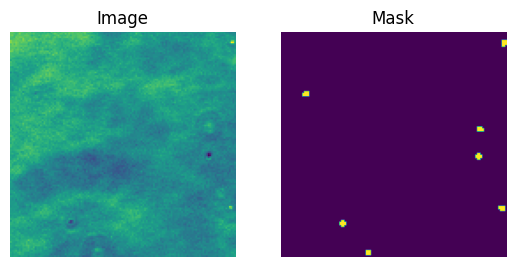

In [18]:
# Set constants
shape = (128, 128)
scale = 4
row = 0
col = 0

# Load images and masks
base_dir = os.path.dirname(os.getcwd())  # Base directory is one level up from this `tutorials` directory
img = Image.open(os.path.join(base_dir, 'data/bdello/images/img1.png'))
mask = Image.open(os.path.join(base_dir, 'data/bdello/masks/img1.png'))

# Convert images and masks to tensors
img = transforms.ToTensor()(img)
mask = transforms.ToTensor()(mask)

# Scale images and masks
img = torch.nn.functional.avg_pool2d(img, scale)
mask = torch.nn.functional.avg_pool2d(mask.float(), scale)

# Convert masks to binary
mask = (mask > 0).long()

# Crop the image and mask
img = img[:, row:row + shape[0], col:col + shape[1]]
mask = mask[:, row:row + shape[0], col:col + shape[1]]

# Visualize the first image and mask
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.numpy().transpose(1, 2, 0))  # Transpose the image tensor to (H, W, C)
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(mask.numpy()[0])  # The mask is a single channel tensor
ax[1].set_title('Mask')
ax[1].axis('off')
plt.show()

In principle, we could use the above code to load images and masks for training a deep learning model. However, this approach is not scalable or efficient, especially when dealing with large datasets. To address these issues, we will now introduce PyTorch Datasets and DataLoaders, which provide a more organized and streamlined way to manage data in PyTorch.

## Dataset Basics

A Dataset in PyTorch is a class that packages the data and its corresponding labels (if applicable) into a single object. By creating a custom Dataset class, we can define how the data is loaded, transformed, and preprocessed before being fed into the model. This encapsulation of data handling logic makes your code more modular, reusable, and maintainable.

A PyTorch Dataset class must inherit from `torch.utils.data.Dataset` and implement two essential methods: `__len__` and `__getitem__`. The `__len__` method returns the total number of samples in the dataset, while the `__getitem__` method loads and returns a sample given its index. By following this structure, we can seamlessly integrate our custom datasets with PyTorch's DataLoader class, which automates the process of batching, shuffling, and loading data in parallel.

In the following code we give an example of a minimal custom Dataset class, where the data is simply the integers from 0 to 9. We define the class and then create a small loop to iterate over the dataset and print the samples:

In [19]:
# Define a minimal working custom dataset
class MyDataset(Dataset):
    def __init__(self):
        self.numbers = list(range(10))

    def __len__(self):
        return len(self.numbers)
    
    def __getitem__(self, idx):
        return self.numbers[idx]
    
# Instantiate the custom dataset
dataset = MyDataset()

# Print examples
print(f'Length of dataset: {len(dataset)}')
print(f'First example: {dataset[0]}')
print(f'Second example: {dataset[1]}')

Length of dataset: 10
First example: 0
Second example: 1
